# Image processing notebook: From overlap corrected to transmission 

### 00 - Introduction
This notebook demonstrates the use of Jupyter for a Time-of-Flight image processing task. The data corresponds to ToF neutron imaging of coin cells filled with different organic compounds and electrolytes.

*Note: This notebook was written and tested on Windows 10. Running on Mac or Linux machines may need adjustments, e.g. in the path specificationsApplied processing*

### Applied processing
The following processing parts from the averaged pulses, which were already overlap corrected:

- filtering
- Pulse averaging and separtion per experiments
- identification and weighting of OBs for each experiment
- scrubbing correction
- intensity correction
- transmission image generation


### Important Considerations
This notebook starts from the point **after** the overlap correction presented in the image below. This step before (done in a separate notebook) format its destionation directory to be taken by this notebook to process the images correctly.

Transmission Image:

\begin{equation}
T_{img} \rightarrow \frac{I}{I_{0}}=\frac{\frac{\bar{Img}}{OB_{weight}} - SBKG_{img}}{\frac{\bar{Ref}}{OB_{weight}} - SBKG_{ref}}
\end{equation}

## 01 Initial settings
Import all the required libraries

In [1]:
import sys
sys.path.append(r'..\framework')
sys.path.append(r'..\proc_functions')
from stack_proc_func import *
from img_utils_mod import *
import scipy.signal as sp
%matplotlib inline

### Select directories
Select the source directory. This directory is where the images **after** the overlap correction were saved.
Select the destination directory. Here is where the transmission images are going to be saved.

In [2]:
# %load select_directory('src_dir')
src_dir = r"E:\External_Tony\Processed\exp3XX\00_Overlap_corrected"

In [3]:
# %load select_directory('dst_dir')
dst_dir = r"E:\External_Tony\Processed\exp3XX\01_Transmission_results"

### Select working folders
Once the directories are loaded, you can start to do a selection of the folders you want to process. <br>
The next function loads the folders availableas a visual aid. However, you can avoid this step just by looking at the source folder in the windows explorer.

In [4]:
all_folders = prep_stack_dict(src_dir)
for key in all_folders.keys():
    print(key)

00_ob_ini
01_so_ref
02_exp301_00
03_exp301_02
04_exp301_03


For this test we will select some folders that we want to process as '`proc_folder`' and our reference as '`ref_folder`'.

* _note: `proc-folder` can take several strings as value, for that reason is a list of strings. On the other hand, `ref_folder` is always one, for that reason it is just a string._

In [5]:
proc_folder_01 = ["02_exp301_00", "03_exp301_02", "04_exp301_03"]

ref_folder = '01_so_ref'

## 02 Filtering process definition
Here we define the process that each image will have before the pulse averaging (if any).

* _note: The sequence generated must contain the names of each function and at the end the 'stack_avg' function which performs the pulse averaging. <br> i.e.  test_seq = [`function_1`, `function_2`, `more functions`, `stack_avg`]_

### White spots filtering
The white spots are removed by applying a median filter of size 'ws_filter_size'

In [6]:
from skimage.filters import gaussian, median, meijering
from skimage.morphology import disk

def ws_filter(src_img, ws_filter_size, **kwargs):
    return sp.medfilt2d(src_img.astype('float32'), ws_filter_size)

def gaussian_filter(x, sigma,**kwargs):
    return gaussian(x, sigma)

def outlier_removal (img, threshold, **kwargs):
    mask_x = np.where(img <= threshold)[0]
    mask_y = np.where(img <= threshold)[1]
    for x, y in zip(mask_x, mask_y) :
        slice = img[max(0, x-1):x+1, max(0,y-1):y+1] # assuming you want 5x5 square
        img[x,y] = np.mean([i for i in slice.flatten() if i > threshold])  # threshold is 0
    return img

def median_filter(x, **kwargs):
    return median(x)
def remove_nan (img, **kwargs):
    return np.nan_to_num(img)

In [7]:
roi_crop = [29, 337, 419, 129]

In [8]:
test_seq = [crop_img, outlier_removal, stack_avg]

## 03 Filter testing
The `test_filter_stack` function test the filters given in the `test_seq` list and prints the image.<br> A selection of a testing folder named `test_folder` is required to proceed with the image checkout. <br> 
-If no specific image is selected, it automatically selects the image at the median point in the stack.<br>

* _note: if the filtering functions inserted in the `test_seq` require aditional arguments or variables, they can be given as `**kwargs` inside the function parameters. i.e `ws_filter_size = 5` was given in the function for the ws_filter usage._

threshold = 0
roi_crop = [29, 337, 419, 129]


Averaging: 100%|███████████████████████████████| 28/28 [00:00<00:00, 36.38it/s]


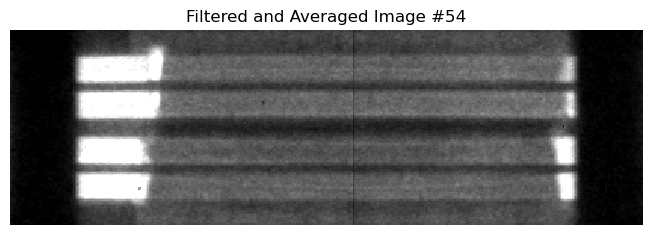

threshold = 0
roi_crop = [29, 337, 419, 129]


Averaging: 100%|███████████████████████████████| 28/28 [00:07<00:00,  3.72it/s]


In [9]:
test_folder = '02_exp301_00'
img = test_filtering_stack (src_dir,dst_dir, test_folder = test_folder, 
                            test_seq = test_seq, give_img=True, threshold = 0, roi_crop = roi_crop)
img_stack = test_filtering_stack (src_dir,dst_dir, test_folder = test_folder, 
                            test_seq = test_seq, give_stack=True, threshold = 0, roi_crop = roi_crop)
img_list = []
for key, value in img_stack.items():
    for imgs in value:
        img_list.append(imgs[0])


### Confirm the operations sequence
After you are satisfied with the result, write the real sequence `seq` that will be used for all the images.

In [10]:
seq = [crop_img, outlier_removal]

## 04 Selecting ROIS and other variables
Each campaign is different, if there are some requirements that the processing require, you can insert them as `**kwargs`. <br>
In the case of this specific campaing (PSI19_03NI), the MCP detector did not adquire correctly the first 9 images in each process. For that reason, the processing needs to remove those images. Thus, we can slice the folder by givin the values that we want with `start_slice` and `end_slice`. 

* _note: If we want to slice the starting but not the end, it is just required to give the beginning (`start_slice`) and leave `end_slice` blank as in the next example._

### ROI selection (program still needs the implementation of the CSV option)
One important parameter are the ROIs, specifically the non-changing-area (nca). Fo that reason, we do a use an interactive command to select them.

If more ROIs were selected (other than the first -nca-), these will be used to create a CSV file at the end with the all the transmission values included. <br>**waiting for implementation in stack_batch_proc**

The window for ROI selection still open in a separate window, I am checking the way to have it printed in the notebook to avoid changing any mistake 

* _note: the option 'flip_image = True' is required to agree with imageJ format of showing the image. In stack_batch_proc it is implemented in the intensity correction part (TFC_corr). The modifications done to img_utils _

**to select several ROIs: for each ROI selected, press ENTER, when finish, press ESC**

In [11]:
# %load select_rois(img, list_rois = ['nca'])
nca = [47, 42, 37, 13]

To agree with the selected ROIs, the image is shown with its labeling, being label 1 the first ROI selected i.e nca, second label 2 and so forth

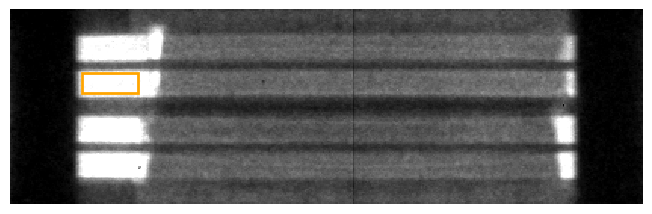

In [12]:
show_img(img, dr = [nca])

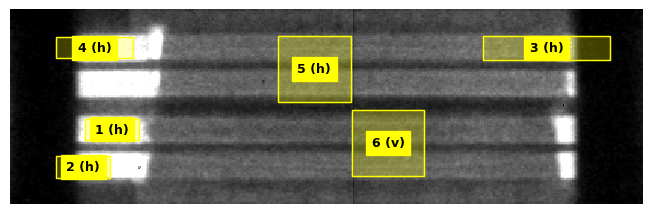

In [13]:
reg_img = get_img(src_dir + '/reg_img_LE.fits')
reg_rois = reg_rois = [([49, 72, 36, 14], 'h'), ([30, 97, 36, 14], 'h'), ([313, 17, 84, 16], 'h'), ([30, 18, 51, 14], 'h'),
([177, 17, 48, 44], 'h'), ([226, 66, 48, 44], 'v')]#, ([23, 19, 27, 90], 'v'), ([413, 70, 27, 39], 'v')]
show_img_rois(img, dr = [(reg_rois, 'yellow')])

In [14]:
img_reg_corr1, res1 = img_registration (img, reg_img[0], num_iter =3, method = '2', rois_list = reg_rois, dof=['tx','ty'])
img_reg_corr2, res2 = img_registration (img, reg_img[0], num_iter =3, method = '3', rois_list = reg_rois, dof=['tx','ty'])

{'tvec': array([ 0.00737684, -0.00036114]), 'success': 0.5417450399232889, 'angle': -0.007013326611826187, 'scale': 1.000201987423878, 'Dscale': 0.002556438114382404, 'Dangle': 0.10739856801909307, 'Dt': 0.25, 'timg': array([[6.73463844, 6.5860867 , 5.79488439, ..., 7.84426332, 6.87847525,
        6.78510507],
       [6.05958381, 6.61797309, 6.15701173, ..., 7.41430303, 7.31306384,
        7.7621553 ],
       [6.93326574, 6.27887263, 5.42269506, ..., 7.31311373, 6.56483324,
        7.56748864],
       ...,
       [8.07790131, 6.21520573, 6.61183585, ..., 7.90156651, 7.90198139,
        7.18822584],
       [8.59071713, 7.57430974, 7.18503279, ..., 7.47739774, 7.94746179,
        7.66640291],
       [8.55068104, 7.89521018, 7.26851434, ..., 7.86427373, 7.71569327,
        8.38491016]])}


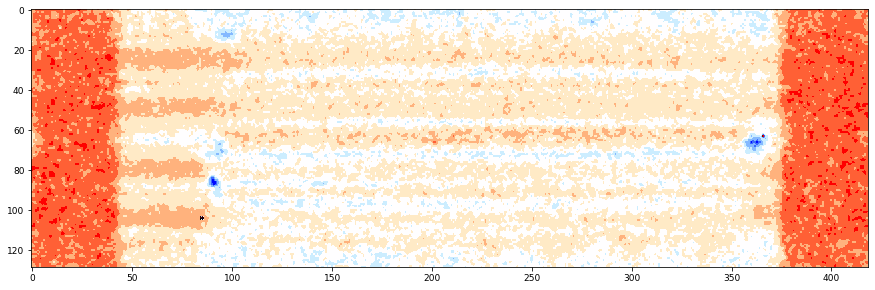

In [15]:
plt.rcParams['figure.figsize'] = [15, 8]
plt.imshow(img_reg_corr1/reg_img[0], cmap = 'flag')
print(res1)

[[ 1.    0.   -0.3 ]
 [ 0.    1.    0.02]
 [ 0.    0.    1.  ]]


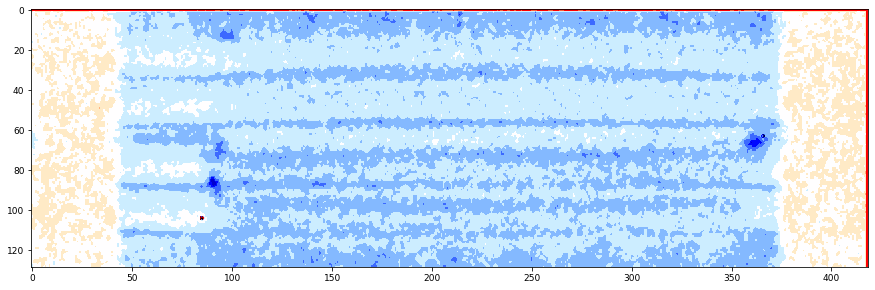

In [16]:
plt.rcParams['figure.figsize'] = [15, 8]
plt.imshow(img_reg_corr2/reg_img[0], cmap = 'flag')
print(res2)

## 05 BB mask
The BB mask is a fits image saved in the source directory. if all the experiments are aligned, one BB mask can be used. However, if there are misalignments, several BB masks must be given. 

**a program that creates the BB mask for that specific experiment would be extremly useful in this case so we do not need to care anymore about BBs**

For the moment being and as an example, the program takes a real (for testing) BB mask to include it in the process

In [17]:
ref_mask_img = get_img(src_dir + '/bb_mask.fits')
img_mask_img = get_img(src_dir + '/bb_mask.fits')

## 06 Run first transmission image test 
This will give you one transmission image as an example of the whole process.

Set a starting and ending slice (to speed up the process, do not choose more tan 10 images or do it in different parts of the spectrum)

In [18]:
stack_test = stack_batch_proc (src_dir, dst_dir, ref_mask_img,img_mask_img, reg_img, proc_folder = [test_folder], 
         ref_folder = ref_folder, avg_seq = seq, save_results = False, start_slice = 30, end_slice = 40, 
         print_TFC = True, nca=nca, threshold = 0, roi_crop =roi_crop, stack_avg=False, scrubbing=True, 
        HE_LE = ([3,18],[68,83]), num_iter = 3, method = '3', rois_list = reg_rois)

start_slice = 30
end_slice = 40
print_TFC = True
nca = [47, 42, 37, 13]
threshold = 0
roi_crop = [29, 337, 419, 129]
stack_avg = False
num_iter = 3
method = 3
rois_list = [([49, 72, 36, 14], 'h'), ([30, 97, 36, 14], 'h'), ([313, 17, 84, 16], 'h'), ([30, 18, 51, 14], 'h'), ([177, 17, 48, 44], 'h'), ([226, 66, 48, 44], 'v')]


Processing: 100%|██████████████████████████████| 28/28 [00:07<00:00,  3.64it/s]


Performing Scrubbing Correction
Performing Image Registration for exp 02_exp301_00 with method 3
01_so_ref
01_so_ref


Processing: 100%|██████████████████████████████| 10/10 [00:00<00:00, 20.06it/s]


02_exp301_00


Processing: 100%|██████████████████████████████| 10/10 [00:00<00:00, 17.81it/s]


ref folder processing: folder_00
area cropped (img) = 0.35308675644507526
area cropped (ref) = 0.35527005715752324
1.0061834681493855
area cropped (img) = 0.3554476041043204
area cropped (ref) = 0.3556905518734763
1.0006834981199777
area cropped (img) = 0.356568666823846
area cropped (ref) = 0.35358127212288915
0.9916218249697394
area cropped (img) = 0.35692040638238914
area cropped (ref) = 0.3459520439478806
0.9692694442840079
area cropped (img) = 0.3492107011807509
area cropped (ref) = 0.335158407512257
0.9597598423502478
area cropped (img) = 0.35715528364060306
area cropped (ref) = 0.3299486895995433
0.923824187161019
area cropped (img) = 0.34160552830714397
area cropped (ref) = 0.3352264786566505
0.9813262692729084
area cropped (img) = 0.33679949194704495
area cropped (ref) = 0.3247865028810268
0.9643319264035382
area cropped (img) = 0.3383011208137199
area cropped (ref) = 0.32664526037369596
0.9655459006107106
area cropped (img) = 0.3292735228874464
area cropped (ref) = 0.31657929

### Testing the NCA region 

This region is characterized for having a value of 1. The process might have an error if this region has values greater that 0.05% of the theoretical one.

In [19]:
nca_reg =[]
for key, val in stack_test.items():
    print(key)
    for key2, im in val.items():
        print(key2)
        for arr in im:
            nca_reg.append(np.mean(roi_in_image(arr[0],nca)))
        print('value cropped reg {}'.format(np.mean(nca_reg)))
        print(nca_reg)
print(len(nca_reg))
print('Average value in the NCA is {}'.format(np.mean(nca_reg)))

02_exp301_00
folder_00
value cropped reg 1.000792774151654
[1.0005782214314607, 0.9971061729114671, 0.9991628091709419, 1.0021458469426947, 1.0004056452122956, 1.0007717570141519, 1.0015443964401942, 1.0022680220694975, 1.0029697801847939, 1.0009750901390433]
folder_01
value cropped reg 1.0008396576705527
[1.0005782214314607, 0.9971061729114671, 0.9991628091709419, 1.0021458469426947, 1.0004056452122956, 1.0007717570141519, 1.0015443964401942, 1.0022680220694975, 1.0029697801847939, 1.0009750901390433, 1.000826582485526, 1.0003046011584003, 1.0012246046959132, 1.001309504838105, 1.0009952620016578, 1.00249658118843, 1.0017062544053732, 0.9977297983619348, 1.0016111997666448, 1.0006610229925237]
folder_02
value cropped reg 1.0008381633283434
[1.0005782214314607, 0.9971061729114671, 0.9991628091709419, 1.0021458469426947, 1.0004056452122956, 1.0007717570141519, 1.0015443964401942, 1.0022680220694975, 1.0029697801847939, 1.0009750901390433, 1.000826582485526, 1.0003046011584003, 1.0012246

## 07 Full image processing
After all tests are correct, you can process and do the full image process for all the folders that you want with the captured parameters.

The result of using the next function is that all the transmission images generated with it are saved with a .fits extension in your destination folder and HE and LE sections will be saved in another 2 folders.

__Note:__ If you are sure fo the process, you can leave `proc_folder` empty `proc_folder = []`,the program will process all folders included in the source directory.

In [20]:
stack_batch_proc (src_dir, dst_dir, ref_mask_img, img_mask_img, reg_img, proc_folder = proc_folder_01, 
                  ref_folder = ref_folder, avg_seq = seq ,nca=nca, threshold = 0, roi_crop =roi_crop, 
                  stack_avg=False, scrubbing=True, HE_LE = ([3,18],[68,83]),num_iter = 3, method = '3', rois_list = reg_rois)

nca = [47, 42, 37, 13]
threshold = 0
roi_crop = [29, 337, 419, 129]
stack_avg = False
num_iter = 3
method = 3
rois_list = [([49, 72, 36, 14], 'h'), ([30, 97, 36, 14], 'h'), ([313, 17, 84, 16], 'h'), ([30, 18, 51, 14], 'h'), ([177, 17, 48, 44], 'h'), ([226, 66, 48, 44], 'v')]


Processing: 100%|██████████████████████████████| 22/22 [01:10<00:00,  3.20s/it]


Performing Scrubbing Correction
Performing Image Registration for exp 02_exp301_00 with method 3
Performing Image Registration for exp 03_exp301_02 with method 3
Performing Image Registration for exp 04_exp301_03 with method 3
01_so_ref
01_so_ref


Processing: 100%|████████████████████████████| 109/109 [00:05<00:00, 21.11it/s]


02_exp301_00


Processing: 100%|████████████████████████████| 109/109 [00:05<00:00, 20.38it/s]


03_exp301_02


Processing: 100%|████████████████████████████| 109/109 [00:05<00:00, 19.93it/s]


04_exp301_03


Processing: 100%|████████████████████████████| 109/109 [00:05<00:00, 19.65it/s]


ref folder processing: folder_00
area cropped (img) = 0.1977268262737608
area cropped (ref) = 0.1732876382465962
area cropped (img) = 0.19586818394154093
area cropped (ref) = 0.19307684015405294
area cropped (img) = 0.23443995516839045
area cropped (ref) = 0.20684543203346462
area cropped (img) = 0.21574086227475317
area cropped (ref) = 0.2218605619525558
area cropped (img) = 0.23573678238963303
area cropped (ref) = 0.2397776313210387
area cropped (img) = 0.25284316701105397
area cropped (ref) = 0.25152540858199807
area cropped (img) = 0.27478966838573954
area cropped (ref) = 0.26694677042013665
area cropped (img) = 0.30709961932664637
area cropped (ref) = 0.29431703624307104
area cropped (img) = 0.29464096374699655
area cropped (ref) = 0.29844046382026124
area cropped (img) = 0.3471102737577532
area cropped (ref) = 0.3279115443659857
area cropped (img) = 0.35948371184775585
area cropped (ref) = 0.33622021585095946
area cropped (img) = 0.36780368134745595
area cropped (ref) = 0.3600692

area cropped (img) = 0.2849904629150571
area cropped (ref) = 0.3060000968738068
area cropped (img) = 0.2595412162477944
area cropped (ref) = 0.29444683423851975
area cropped (img) = 0.25824712520128
area cropped (ref) = 0.28686920160288804
area cropped (img) = 0.2603505631065218
area cropped (ref) = 0.28102852116218885
area cropped (img) = 0.2575962408984827
area cropped (ref) = 0.2821110695672624
area cropped (img) = 0.23744315690988896
area cropped (ref) = 0.2750506793854489
area cropped (img) = 0.2449221216781392
area cropped (ref) = 0.27799815504708064
area cropped (img) = 0.2631475646203226
area cropped (ref) = 0.2611923774239597
area cropped (img) = 0.25942359229451606
area cropped (ref) = 0.2619640242880938
area cropped (img) = 0.22102254271077343
area cropped (ref) = 0.2523114064513044
area cropped (img) = 0.2104338784607514
area cropped (ref) = 0.24846326144003814
area cropped (img) = 0.22484214807555947
area cropped (ref) = 0.24250150001352225
area cropped (img) = 0.223305411

area cropped (img) = 0.1427608482554293
area cropped (ref) = 0.16402647076382942
area cropped (img) = 0.18757362541724237
area cropped (ref) = 0.1577135974241715
area cropped (img) = 0.17403266339888734
area cropped (ref) = 0.1594197893385456
area cropped (img) = 0.13415816098028477
area cropped (ref) = 0.15196020907535776
area cropped (img) = 0.17022113682089154
area cropped (ref) = 0.14551438648725767
area cropped (img) = 0.15130552348191786
area cropped (ref) = 0.14172493767660396
area cropped (img) = 0.1418999429903127
area cropped (ref) = 0.13564499164664712
area cropped (img) = 0.13543780590512888
area cropped (ref) = 0.12922112638840902
area cropped (img) = 0.12161049950049299
area cropped (ref) = 0.1252983592108285
area cropped (img) = 0.12678918116148563
area cropped (ref) = 0.11920462035226403
area cropped (img) = 0.09583120263217604
area cropped (ref) = 0.11146613899702942
area cropped (img) = 0.11721509773713198
area cropped (ref) = 0.1074466585628777
area cropped (img) = 0

area cropped (img) = 0.5061940536800996
area cropped (ref) = 0.5481553906136212
area cropped (img) = 0.48901076244335356
area cropped (ref) = 0.5546127907348383
area cropped (img) = 0.5006673823047029
area cropped (ref) = 0.5617859112662497
area cropped (img) = 0.5164304212158003
area cropped (ref) = 0.5621172347204813
area cropped (img) = 0.5309435620831336
area cropped (ref) = 0.5708623772200189
area cropped (img) = 0.5484585659968731
area cropped (ref) = 0.5857594512700325
area cropped (img) = 0.5089769247558308
area cropped (ref) = 0.5826058122954589
area cropped (img) = 0.49222180233355883
area cropped (ref) = 0.5840632852380624
area cropped (img) = 0.5488465373043134
area cropped (ref) = 0.5889983030812548
area cropped (img) = 0.530947416063349
area cropped (ref) = 0.5860074284991174
area cropped (img) = 0.5209513209218697
area cropped (ref) = 0.5943238294532798
area cropped (img) = 0.5004982280392247
area cropped (ref) = 0.5951060461371394
area cropped (img) = 0.5035975292181752

area cropped (ref) = 0.4452020484211625
area cropped (img) = 0.4335793129979353
area cropped (ref) = 0.4388571441468729
area cropped (img) = 0.4295976579256847
area cropped (ref) = 0.42308485953069647
area cropped (img) = 0.4493083852991048
area cropped (ref) = 0.4175622453490518
area cropped (img) = 0.41766090821787893
area cropped (ref) = 0.39826551622745954
area cropped (img) = 0.4043995699743724
area cropped (ref) = 0.40138438667467674
area cropped (img) = 0.37966508567866847
area cropped (ref) = 0.3837206117037486
area cropped (img) = 0.3741127079603771
area cropped (ref) = 0.37806860981979984
area cropped (img) = 0.397120309128994
area cropped (ref) = 0.36830295301340027
area cropped (img) = 0.3875937517677761
area cropped (ref) = 0.3695047180252976
area cropped (img) = 0.3580757783550139
area cropped (ref) = 0.36119835193541316
area cropped (img) = 0.3675534315116597
area cropped (ref) = 0.3482177329280377
area cropped (img) = 0.3573314054628992
area cropped (ref) = 0.3433327797

area cropped (img) = 0.5909240268687361
area cropped (ref) = 0.5546127907348383
area cropped (img) = 0.5868320543231274
area cropped (ref) = 0.5617859112662497
area cropped (img) = 0.6041425233019986
area cropped (ref) = 0.5621172347204813
area cropped (img) = 0.5972869027549942
area cropped (ref) = 0.5708623772200189
area cropped (img) = 0.5920065013204046
area cropped (ref) = 0.5857594512700325
area cropped (img) = 0.6086641599573901
area cropped (ref) = 0.5826058122954589
area cropped (img) = 0.5819678611301107
area cropped (ref) = 0.5840632852380624
area cropped (img) = 0.6261351413442529
area cropped (ref) = 0.5889983030812548
area cropped (img) = 0.5964498516899098
area cropped (ref) = 0.5860074284991174
area cropped (img) = 0.5783296480220521
area cropped (ref) = 0.5943238294532798
area cropped (img) = 0.6292511987754307
area cropped (ref) = 0.5951060461371394
area cropped (img) = 0.603632348240109
area cropped (ref) = 0.5915122599808257
area cropped (img) = 0.6050392628925163
a

area cropped (img) = 0.3608519980389553
area cropped (ref) = 0.3915272090042977
area cropped (img) = 0.35244969653096503
area cropped (ref) = 0.4094908647273866
area cropped (img) = 0.3535634937900669
area cropped (ref) = 0.4216874589640572
area cropped (img) = 0.46060339939086015
area cropped (ref) = 0.5050143770946826
area cropped (img) = 0.49510822795820697
area cropped (ref) = 0.5077326799698342
area cropped (img) = 0.48956801239937536
area cropped (ref) = 0.5261944330601827
area cropped (img) = 0.49598048370527303
area cropped (ref) = 0.5337371566622889
area cropped (img) = 0.49255703069931756
area cropped (ref) = 0.5481553906136212
area cropped (img) = 0.5228372375047394
area cropped (ref) = 0.5546127907348383
area cropped (img) = 0.5070819031399256
area cropped (ref) = 0.5617859112662497
area cropped (img) = 0.5421371980393788
area cropped (ref) = 0.5621172347204813
area cropped (img) = 0.5548425243186619
area cropped (ref) = 0.5708623772200189
area cropped (img) = 0.49812349286

area cropped (img) = 0.0813686322774018
area cropped (ref) = 0.081218108514466
area cropped (img) = 0.083156909329477
area cropped (ref) = 0.07548259159840504
area cropped (img) = 0.07869440552331865
area cropped (ref) = 0.08449079821869192
area cropped (img) = 0.07729877399355446
area cropped (ref) = 0.0695886990597244
ref folder processing: folder_25
area cropped (img) = 0.16036641314276656
area cropped (ref) = 0.1732876382465962
area cropped (img) = 0.15444432579278025
area cropped (ref) = 0.19307684015405294
area cropped (img) = 0.2074988270458566
area cropped (ref) = 0.20684543203346462
area cropped (img) = 0.22726991524186602
area cropped (ref) = 0.2218605619525558
area cropped (img) = 0.224430965749178
area cropped (ref) = 0.2397776313210387
area cropped (img) = 0.24658623805464017
area cropped (ref) = 0.25152540858199807
area cropped (img) = 0.27585781586750246
area cropped (ref) = 0.26694677042013665
area cropped (img) = 0.2844167504009895
area cropped (ref) = 0.29431703624307

area cropped (img) = 0.08665233092671472
area cropped (ref) = 0.09313906968637803
area cropped (img) = 0.09485803880820123
area cropped (ref) = 0.09422173371743241
area cropped (img) = 0.08110658310573046
area cropped (ref) = 0.08888937969780017
area cropped (img) = 0.09931805690011677
area cropped (ref) = 0.081218108514466
area cropped (img) = 0.07563559135297025
area cropped (ref) = 0.07548259159840504
area cropped (img) = 0.07095619270994247
area cropped (ref) = 0.08449079821869192
area cropped (img) = 0.08218624398250275
area cropped (ref) = 0.0695886990597244
ref folder processing: folder_01
area cropped (img) = 0.18624487150950575
area cropped (ref) = 0.1732876382465962
area cropped (img) = 0.19988859945576612
area cropped (ref) = 0.19307684015405294
area cropped (img) = 0.18565818290176664
area cropped (ref) = 0.20684543203346462
area cropped (img) = 0.20609719574673319
area cropped (ref) = 0.2218605619525558
area cropped (img) = 0.21162607227939817
area cropped (ref) = 0.239777

area cropped (img) = 0.17171655798875607
area cropped (ref) = 0.19798975512502004
area cropped (img) = 0.1846386305049057
area cropped (ref) = 0.18681263280769894
area cropped (img) = 0.13985303926641626
area cropped (ref) = 0.1791371786964645
area cropped (img) = 0.15601665255749658
area cropped (ref) = 0.1828537361789992
area cropped (img) = 0.1631853535668429
area cropped (ref) = 0.16402647076382942
area cropped (img) = 0.13484779475403041
area cropped (ref) = 0.1577135974241715
area cropped (img) = 0.15300588560396577
area cropped (ref) = 0.1594197893385456
area cropped (img) = 0.1519840361185009
area cropped (ref) = 0.15196020907535776
area cropped (img) = 0.13466564754483798
area cropped (ref) = 0.14551438648725767
area cropped (img) = 0.1357953153604308
area cropped (ref) = 0.14172493767660396
area cropped (img) = 0.11620457074964088
area cropped (ref) = 0.13564499164664712
area cropped (img) = 0.1101564545962504
area cropped (ref) = 0.12922112638840902
area cropped (img) = 0.12

area cropped (img) = 0.3860089446896781
area cropped (ref) = 0.33622021585095946
area cropped (img) = 0.3842813632791005
area cropped (ref) = 0.3600692325450084
area cropped (img) = 0.3821150747206191
area cropped (ref) = 0.3752863741034814
area cropped (img) = 0.40093159606832335
area cropped (ref) = 0.3915272090042977
area cropped (img) = 0.4101914742158176
area cropped (ref) = 0.4094908647273866
area cropped (img) = 0.40881761923318616
area cropped (ref) = 0.4216874589640572
area cropped (img) = 0.48330319857037324
area cropped (ref) = 0.5050143770946826
area cropped (img) = 0.5246867645973469
area cropped (ref) = 0.5077326799698342
area cropped (img) = 0.547029414119981
area cropped (ref) = 0.5261944330601827
area cropped (img) = 0.5640961317549348
area cropped (ref) = 0.5337371566622889
area cropped (img) = 0.5573525121422096
area cropped (ref) = 0.5481553906136212
area cropped (img) = 0.5615478921438489
area cropped (ref) = 0.5546127907348383
area cropped (img) = 0.57992833671697

area cropped (img) = 0.4400183580133402
area cropped (ref) = 0.4630844909281741
area cropped (img) = 0.473043252875489
area cropped (ref) = 0.4547517416673882
area cropped (img) = 0.41085336990292304
area cropped (ref) = 0.4452020484211625
area cropped (img) = 0.4337912869457407
area cropped (ref) = 0.4388571441468729
area cropped (img) = 0.40780963636943757
area cropped (ref) = 0.42308485953069647
area cropped (img) = 0.40488365691081907
area cropped (ref) = 0.4175622453490518
area cropped (img) = 0.4472464171754476
area cropped (ref) = 0.39826551622745954
area cropped (img) = 0.4005307891071307
area cropped (ref) = 0.40138438667467674
area cropped (img) = 0.36737251959427536
area cropped (ref) = 0.3837206117037486
area cropped (img) = 0.3905347959879049
area cropped (ref) = 0.37806860981979984
area cropped (img) = 0.373257656348505
area cropped (ref) = 0.36830295301340027
area cropped (img) = 0.3898101206515242
area cropped (ref) = 0.3695047180252976
area cropped (img) = 0.3814332382

area cropped (img) = 0.2615820204395307
area cropped (ref) = 0.24458356225932895
area cropped (img) = 0.24807611499734694
area cropped (ref) = 0.23296453018049215
area cropped (img) = 0.2313329298866923
area cropped (ref) = 0.22767639436167308
area cropped (img) = 0.22768665383642764
area cropped (ref) = 0.22223294763618034
area cropped (img) = 0.2337241043347623
area cropped (ref) = 0.21545647766719891
area cropped (img) = 0.22900956805147887
area cropped (ref) = 0.20597859547092884
area cropped (img) = 0.194130916543047
area cropped (ref) = 0.2012139119369709
area cropped (img) = 0.2125683426697799
area cropped (ref) = 0.19798975512502004
area cropped (img) = 0.19703363115299316
area cropped (ref) = 0.18681263280769894
area cropped (img) = 0.2040859485223997
area cropped (ref) = 0.1791371786964645
area cropped (img) = 0.16952120497984485
area cropped (ref) = 0.1828537361789992
area cropped (img) = 0.20541240502870903
area cropped (ref) = 0.16402647076382942
area cropped (img) = 0.161

area cropped (img) = 0.105765107191881
area cropped (ref) = 0.09524156066352801
area cropped (img) = 0.07783174564975268
area cropped (ref) = 0.09313906968637803
area cropped (img) = 0.09023931091548418
area cropped (ref) = 0.09422173371743241
area cropped (img) = 0.07586605388310558
area cropped (ref) = 0.08888937969780017
area cropped (img) = 0.11058342245077203
area cropped (ref) = 0.081218108514466
area cropped (img) = 0.10259677259631936
area cropped (ref) = 0.07548259159840504
area cropped (img) = 0.07195610709292828
area cropped (ref) = 0.08449079821869192
area cropped (img) = 0.08003147617128223
area cropped (ref) = 0.0695886990597244
ref folder processing: folder_18
area cropped (img) = 0.1939255193171871
area cropped (ref) = 0.1732876382465962
area cropped (img) = 0.18710217060105291
area cropped (ref) = 0.19307684015405294
area cropped (img) = 0.2099420202065359
area cropped (ref) = 0.20684543203346462
area cropped (img) = 0.24114841060396064
area cropped (ref) = 0.221860561

area cropped (img) = 0.4415968501531538
area cropped (ref) = 0.4094908647273866
area cropped (img) = 0.4513207552683935
area cropped (ref) = 0.4216874589640572
area cropped (img) = 0.5278248410248089
area cropped (ref) = 0.5050143770946826
area cropped (img) = 0.4895575775232583
area cropped (ref) = 0.5077326799698342
area cropped (img) = 0.5266561122419008
area cropped (ref) = 0.5261944330601827
area cropped (img) = 0.5408414532771124
area cropped (ref) = 0.5337371566622889
area cropped (img) = 0.56325233923107
area cropped (ref) = 0.5481553906136212
area cropped (img) = 0.5496751598348903
area cropped (ref) = 0.5546127907348383
area cropped (img) = 0.5460573477644723
area cropped (ref) = 0.5617859112662497
area cropped (img) = 0.5671736762608758
area cropped (ref) = 0.5621172347204813
area cropped (img) = 0.5975273777979888
area cropped (ref) = 0.5708623772200189
area cropped (img) = 0.5608636879650383
area cropped (ref) = 0.5857594512700325
area cropped (img) = 0.5984268985554202
ar

area cropped (img) = 0.5204973063990617
area cropped (ref) = 0.49468789534428015
area cropped (img) = 0.48121769090526295
area cropped (ref) = 0.48522040160042507
area cropped (img) = 0.5164344191896773
area cropped (ref) = 0.4780595137326606
area cropped (img) = 0.47801779377833087
area cropped (ref) = 0.4630844909281741
area cropped (img) = 0.47016775025662144
area cropped (ref) = 0.4547517416673882
area cropped (img) = 0.4439965889626389
area cropped (ref) = 0.4452020484211625
area cropped (img) = 0.44639605010796807
area cropped (ref) = 0.4388571441468729
area cropped (img) = 0.4213608554714978
area cropped (ref) = 0.42308485953069647
area cropped (img) = 0.4083001864421438
area cropped (ref) = 0.4175622453490518
area cropped (img) = 0.45675015811074093
area cropped (ref) = 0.39826551622745954
area cropped (img) = 0.4272012653450506
area cropped (ref) = 0.40138438667467674
area cropped (img) = 0.3827094368795353
area cropped (ref) = 0.3837206117037486
area cropped (img) = 0.3706919

area cropped (img) = 0.16717773351308213
area cropped (ref) = 0.1594197893385456
area cropped (img) = 0.16583640764970442
area cropped (ref) = 0.15196020907535776
area cropped (img) = 0.1537736867250438
area cropped (ref) = 0.14551438648725767
area cropped (img) = 0.13993456441242894
area cropped (ref) = 0.14172493767660396
area cropped (img) = 0.14088353770286058
area cropped (ref) = 0.13564499164664712
area cropped (img) = 0.1395173895257883
area cropped (ref) = 0.12922112638840902
area cropped (img) = 0.12224882173293364
area cropped (ref) = 0.1252983592108285
area cropped (img) = 0.12893648793656579
area cropped (ref) = 0.11920462035226403
area cropped (img) = 0.11636905585268971
area cropped (ref) = 0.11146613899702942
area cropped (img) = 0.09340100830956728
area cropped (ref) = 0.1074466585628777
area cropped (img) = 0.13627445738478036
area cropped (ref) = 0.10419666629526557
area cropped (img) = 0.09987552100817225
area cropped (ref) = 0.10117544165165197
area cropped (img) = 

area cropped (img) = 0.24107782548907672
area cropped (ref) = 0.22767639436167308
area cropped (img) = 0.22485505614754187
area cropped (ref) = 0.22223294763618034
area cropped (img) = 0.235063919643287
area cropped (ref) = 0.21545647766719891
area cropped (img) = 0.1877691878845083
area cropped (ref) = 0.20597859547092884
area cropped (img) = 0.20591964147907166
area cropped (ref) = 0.2012139119369709
area cropped (img) = 0.20449027202145967
area cropped (ref) = 0.19798975512502004
area cropped (img) = 0.1657926586012661
area cropped (ref) = 0.18681263280769894
area cropped (img) = 0.17527964939631935
area cropped (ref) = 0.1791371786964645
area cropped (img) = 0.17536070707167448
area cropped (ref) = 0.1828537361789992
area cropped (img) = 0.1598973832846929
area cropped (ref) = 0.16402647076382942
area cropped (img) = 0.16797351051403406
area cropped (ref) = 0.1577135974241715
area cropped (img) = 0.16255083580805824
area cropped (ref) = 0.1594197893385456
area cropped (img) = 0.154

area cropped (img) = 0.5898029616806693
area cropped (ref) = 0.5826058122954589
area cropped (img) = 0.5763378708375847
area cropped (ref) = 0.5840632852380624
area cropped (img) = 0.5430893622441832
area cropped (ref) = 0.5889983030812548
area cropped (img) = 0.5688433634783453
area cropped (ref) = 0.5860074284991174
area cropped (img) = 0.5400742546087192
area cropped (ref) = 0.5943238294532798
area cropped (img) = 0.594137438121103
area cropped (ref) = 0.5951060461371394
area cropped (img) = 0.5778206326067651
area cropped (ref) = 0.5915122599808257
area cropped (img) = 0.5783580582651775
area cropped (ref) = 0.5787497561278415
area cropped (img) = 0.5546675394155741
area cropped (ref) = 0.5607134012949246
area cropped (img) = 0.5075562936052864
area cropped (ref) = 0.5519356109956146
area cropped (img) = 0.5379504482635445
area cropped (ref) = 0.5607915497573899
area cropped (img) = 0.5601906743037508
area cropped (ref) = 0.5432917859631472
area cropped (img) = 0.5220524115233269
a

area cropped (img) = 0.4460802761340026
area cropped (ref) = 0.42308485953069647
area cropped (img) = 0.4170228451855478
area cropped (ref) = 0.4175622453490518
area cropped (img) = 0.39119197078888224
area cropped (ref) = 0.39826551622745954
area cropped (img) = 0.4139932877732791
area cropped (ref) = 0.40138438667467674
area cropped (img) = 0.3880981265398385
area cropped (ref) = 0.3837206117037486
area cropped (img) = 0.36457881111096074
area cropped (ref) = 0.37806860981979984
area cropped (img) = 0.372056272505723
area cropped (ref) = 0.36830295301340027
area cropped (img) = 0.351816955302623
area cropped (ref) = 0.3695047180252976
area cropped (img) = 0.3591239885982786
area cropped (ref) = 0.36119835193541316
area cropped (img) = 0.3458885544196812
area cropped (ref) = 0.3482177329280377
area cropped (img) = 0.3510226099609691
area cropped (ref) = 0.34333277977421606
area cropped (img) = 0.353212753618725
area cropped (ref) = 0.3378430011961618
area cropped (img) = 0.33146319749

area cropped (img) = 0.1960429980175346
area cropped (ref) = 0.23296453018049215
area cropped (img) = 0.19066426964937427
area cropped (ref) = 0.22767639436167308
area cropped (img) = 0.21966257675241313
area cropped (ref) = 0.22223294763618034
area cropped (img) = 0.17840043000524045
area cropped (ref) = 0.21545647766719891
area cropped (img) = 0.17824064834779452
area cropped (ref) = 0.20597859547092884
area cropped (img) = 0.19380121464913447
area cropped (ref) = 0.2012139119369709
area cropped (img) = 0.17946467368254232
area cropped (ref) = 0.19798975512502004
area cropped (img) = 0.18753484899494505
area cropped (ref) = 0.18681263280769894
area cropped (img) = 0.15302131420421858
area cropped (ref) = 0.1791371786964645
area cropped (img) = 0.18490655215839558
area cropped (ref) = 0.1828537361789992
area cropped (img) = 0.15599315633251157
area cropped (ref) = 0.16402647076382942
area cropped (img) = 0.1380108572094185
area cropped (ref) = 0.1577135974241715
area cropped (img) = 0

area cropped (img) = 0.26056690114036674
area cropped (ref) = 0.25152540858199807
area cropped (img) = 0.2904343270523117
area cropped (ref) = 0.26694677042013665
area cropped (img) = 0.26736082704804537
area cropped (ref) = 0.29431703624307104
area cropped (img) = 0.32755825993897486
area cropped (ref) = 0.29844046382026124
area cropped (img) = 0.30162648657725727
area cropped (ref) = 0.3279115443659857
area cropped (img) = 0.3374113301684318
area cropped (ref) = 0.33622021585095946
area cropped (img) = 0.3336729921197329
area cropped (ref) = 0.3600692325450084
area cropped (img) = 0.3853121988493974
area cropped (ref) = 0.3752863741034814
area cropped (img) = 0.37574543419552436
area cropped (ref) = 0.3915272090042977
area cropped (img) = 0.3757440476818763
area cropped (ref) = 0.4094908647273866
area cropped (img) = 0.4508668776505562
area cropped (ref) = 0.4216874589640572
area cropped (img) = 0.5081390358949989
area cropped (ref) = 0.5050143770946826
area cropped (img) = 0.5236560

area cropped (img) = 0.3173935697700979
area cropped (ref) = 0.3311403501317198
area cropped (img) = 0.317137686061102
area cropped (ref) = 0.3175444459997565
area cropped (img) = 0.2743582507765112
area cropped (ref) = 0.3060000968738068
area cropped (img) = 0.31119594555845187
area cropped (ref) = 0.29444683423851975
area cropped (img) = 0.2971126687848211
area cropped (ref) = 0.28686920160288804
area cropped (img) = 0.2884886157658221
area cropped (ref) = 0.28102852116218885
area cropped (img) = 0.30275292664430736
area cropped (ref) = 0.2821110695672624
area cropped (img) = 0.27753517783351567
area cropped (ref) = 0.2750506793854489
area cropped (img) = 0.2793496419712285
area cropped (ref) = 0.27799815504708064
area cropped (img) = 0.26360719081892103
area cropped (ref) = 0.2611923774239597
area cropped (img) = 0.2678159800910368
area cropped (ref) = 0.2619640242880938
area cropped (img) = 0.26417766549864424
area cropped (ref) = 0.2523114064513044
area cropped (img) = 0.237719537

area cropped (img) = 0.2910313990405867
area cropped (ref) = 0.28686920160288804
area cropped (img) = 0.2888081213733111
area cropped (ref) = 0.28102852116218885
area cropped (img) = 0.2958977516328611
area cropped (ref) = 0.2821110695672624
area cropped (img) = 0.26888117418154694
area cropped (ref) = 0.2750506793854489
area cropped (img) = 0.30206495507584985
area cropped (ref) = 0.27799815504708064
area cropped (img) = 0.24500066748864222
area cropped (ref) = 0.2611923774239597
area cropped (img) = 0.27842260841950833
area cropped (ref) = 0.2619640242880938
area cropped (img) = 0.24386162137536396
area cropped (ref) = 0.2523114064513044
area cropped (img) = 0.27230611096912877
area cropped (ref) = 0.24846326144003814
area cropped (img) = 0.2490795716004707
area cropped (ref) = 0.24250150001352225
area cropped (img) = 0.231876465824476
area cropped (ref) = 0.24458356225932895
area cropped (img) = 0.275143818105752
area cropped (ref) = 0.23296453018049215
area cropped (img) = 0.216685

area cropped (img) = 0.2636072600759467
area cropped (ref) = 0.26694677042013665
area cropped (img) = 0.2906383660446114
area cropped (ref) = 0.29431703624307104
area cropped (img) = 0.27674892268927337
area cropped (ref) = 0.29844046382026124
area cropped (img) = 0.2771446422788385
area cropped (ref) = 0.3279115443659857
area cropped (img) = 0.33579003675940033
area cropped (ref) = 0.33622021585095946
area cropped (img) = 0.3498635689774332
area cropped (ref) = 0.3600692325450084
area cropped (img) = 0.38799542131193643
area cropped (ref) = 0.3752863741034814
area cropped (img) = 0.3375445319096293
area cropped (ref) = 0.3915272090042977
area cropped (img) = 0.4009960125098294
area cropped (ref) = 0.4094908647273866
area cropped (img) = 0.4188979841684913
area cropped (ref) = 0.4216874589640572
area cropped (img) = 0.4863390778959653
area cropped (ref) = 0.5050143770946826
area cropped (img) = 0.5057983470514799
area cropped (ref) = 0.5077326799698342
area cropped (img) = 0.5224845838

area cropped (img) = 0.5537781822048591
area cropped (ref) = 0.5464265559784124
area cropped (img) = 0.5266381714080393
area cropped (ref) = 0.5296289957497494
area cropped (img) = 0.5238977678908834
area cropped (ref) = 0.5263189139431821
area cropped (img) = 0.5060007444349454
area cropped (ref) = 0.5109659321525645
area cropped (img) = 0.500394849266623
area cropped (ref) = 0.5081032844355016
area cropped (img) = 0.5051814050428817
area cropped (ref) = 0.49468789534428015
area cropped (img) = 0.4877837142507908
area cropped (ref) = 0.48522040160042507
area cropped (img) = 0.4777641093047671
area cropped (ref) = 0.4780595137326606
area cropped (img) = 0.47970294963909127
area cropped (ref) = 0.4630844909281741
area cropped (img) = 0.44503269491508307
area cropped (ref) = 0.4547517416673882
area cropped (img) = 0.47424929170844626
area cropped (ref) = 0.4452020484211625
area cropped (img) = 0.4381555191633515
area cropped (ref) = 0.4388571441468729
area cropped (img) = 0.4500561543454

area cropped (img) = 0.3312749368774774
area cropped (ref) = 0.3378430011961618
area cropped (img) = 0.3116092313818223
area cropped (ref) = 0.3311403501317198
area cropped (img) = 0.31853664411711724
area cropped (ref) = 0.3175444459997565
area cropped (img) = 0.3032002013567448
area cropped (ref) = 0.3060000968738068
area cropped (img) = 0.2782581391964657
area cropped (ref) = 0.29444683423851975
area cropped (img) = 0.29003079511702945
area cropped (ref) = 0.28686920160288804
area cropped (img) = 0.3045578969769362
area cropped (ref) = 0.28102852116218885
area cropped (img) = 0.29094668261544043
area cropped (ref) = 0.2821110695672624
area cropped (img) = 0.3013971633592676
area cropped (ref) = 0.2750506793854489
area cropped (img) = 0.2597755174459784
area cropped (ref) = 0.27799815504708064
area cropped (img) = 0.26115225616257304
area cropped (ref) = 0.2611923774239597
area cropped (img) = 0.2597172081427339
area cropped (ref) = 0.2619640242880938
area cropped (img) = 0.278217291

Total execution time: 1506s
